In [8]:
from atlite.gis import ExclusionContainer
import atlite
import rasterio as rio
from rasterio.plot import show
import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
import rasterio.crs as crs
import cartopy.crs as ccrs
from shapely.geometry import MultiPolygon, Polygon
from atlite.gis import shape_availability
import rasterio
import xarray as xr
from pyproj import CRS
import seaborn as sns
import matplotlib.lines as mlines

In [9]:
os.chdir("C:\\Users\\alex-\\Documents\\TU Berlin\\EW_Mod\\EW_Mod_Paper")
url = "https://tubcloud.tu-berlin.de/s/RHZJrN8Dnfn26nr/download/NUTS_RG_10M_2021_4326.geojson"
nuts = gpd.read_file(url)
nuts = nuts.query("LEVL_CODE == 1")
nuts = nuts[nuts["CNTR_CODE"].isin(["DE"])]  # Filter for Germany)]  


C:\Users\alex-\AppData\Local\Temp\ipykernel_41664\818591158.py:27: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
C:\Users\alex-\AppData\Local\Temp\ipykernel_41664\818591158.py:54: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


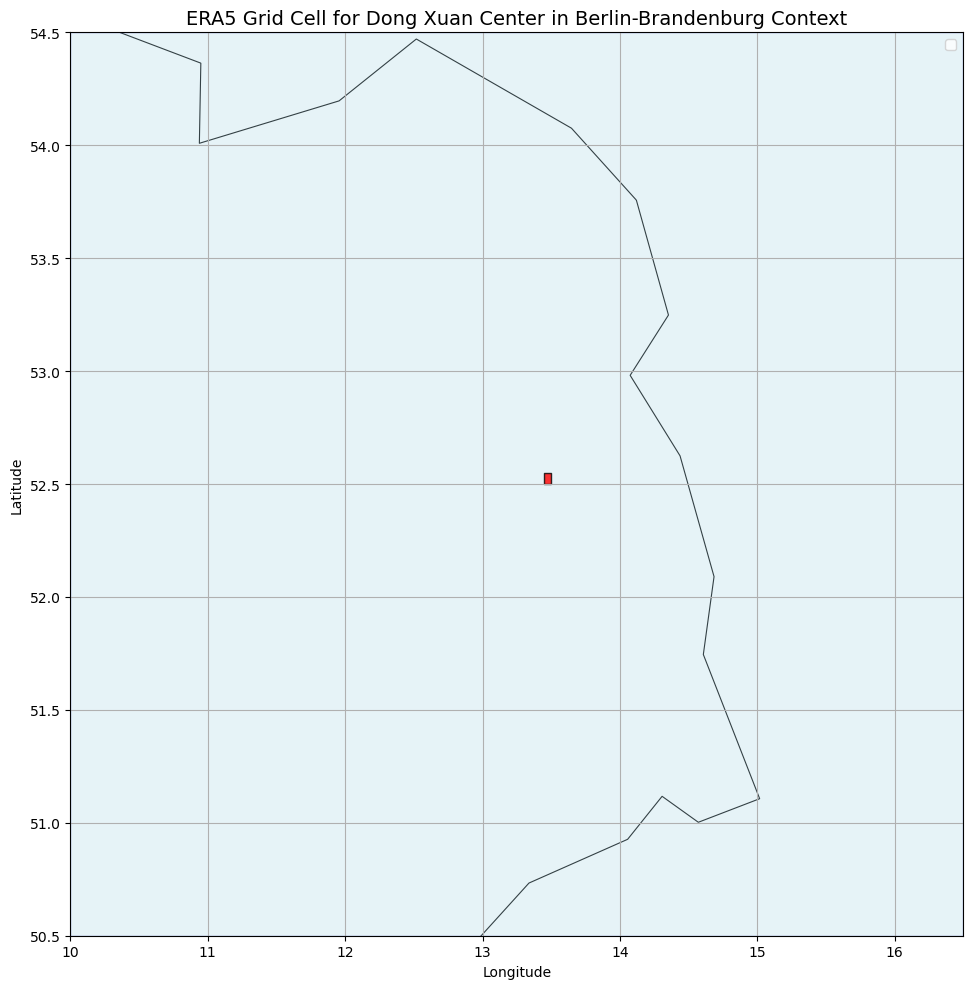

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
import math

# 1. Snap Dong Xuan coordinates to ERA5 0.25° grid
def snap_to_grid(coord, resolution=0.25, direction='lower'):
    if direction == 'lower':
        return math.floor(coord / resolution) * resolution
    elif direction == 'upper':
        return math.ceil(coord / resolution) * resolution

lat = 52.5410
lon = 13.4801
minx = snap_to_grid(lon, 0.05, 'lower')   # 13.25
maxx = snap_to_grid(lon, 0.05, 'upper')   # 13.5
miny = snap_to_grid(lat, 0.05, 'lower')   # 52.5
maxy = snap_to_grid(lat, 0.05, 'upper')   # 52.75

# 2. Create the ERA5 grid cell GeoDataFrame for Dong Xuan Center
dongxuan_cell = gpd.GeoDataFrame(
    geometry=[box(minx, miny, maxx, maxy)],
    crs="EPSG:4326"
)

# 3. Load the Germany base map
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
germany = world[world.name == "Germany"]

# 4. Define Berlin/Brandenburg bounding box as GeoDataFrame
bbox_dict = {
    "minx": 10.0,
    "miny": 50.5,
    "maxx": 16.5,
    "maxy": 54.5,
}
bbox_geom = box(bbox_dict["minx"], bbox_dict["miny"], bbox_dict["maxx"], bbox_dict["maxy"])
bbox_gdf = gpd.GeoDataFrame(geometry=[bbox_geom], crs="EPSG:4326")

# 5. Plot everything in one figure
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

germany.plot(ax=ax, color='white', edgecolor='black', linewidth=0.8)
bbox_gdf.plot(ax=ax, color='lightblue', edgecolor='blue', alpha=0.3, label='Berlin-Brandenburg BBox')
dongxuan_cell.plot(ax=ax, color='red', edgecolor='black', alpha=0.8, label='Dong Xuan ERA5 Cell')

# 6. Set extent and styling
ax.set_xlim(bbox_dict["minx"], bbox_dict["maxx"])
ax.set_ylim(bbox_dict["miny"], bbox_dict["maxy"])
ax.set_title("ERA5 Grid Cell for Dong Xuan Center in Berlin-Brandenburg Context", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()


In [12]:
import atlite
import geopandas as gpd
from shapely.ops import unary_union

# 1. Lade Geometrie (z. B. Dong Xuan Markt)
dongxuan_cell = dongxuan_cell
dongxuan_shape = unary_union(dongxuan_cell.geometry)
dongxuan_shape = dongxuan_shape.buffer(0.01)  # ~1 km Sicherheitspuffer

# 2. Bestimme Bounding Box
delta = 0.5  # ca. 5 km

x1 = minx - delta
x2 = maxx + delta
y1 = miny - delta
y2 = maxy + delta

# 3. Definiere Cutout
cutout = atlite.Cutout(
    path="dongxuan_precise.nc",
    module="era5",
    x=slice(x1, x2),
    y=slice(y2, y1),  # Nord nach Süd!
    time=slice("2014-01-01", "2014-12-31")
)

# 4. Erzeuge/öffne Cutout-Datei (lädt automatisch über CDSAPI)
cutout.prepare(features=["influx", "temperature"])

c:\Users\alex-\anaconda3\Lib\site-packages\cads_api_client\legacy_api_client.py:101: UserWarning: This is a beta version. The following parameters have not been implemented yet: {'info_callback': <bound method Logger.debug of <Logger atlite.datasets.era5 (WARNING)>>}.
  warnings.warn(
2025-07-22 22:06:03,559 WARNING [2025-07-22T20:06:05.165645] You are using a deprecated API endpoint. If you are using cdsapi, please upgrade to the latest version.
2025-07-22 22:06:03,560 INFO Request ID is 2336ee87-dccc-4600-96e9-6c761f152c04
2025-07-22 22:06:03,643 INFO status has been updated to accepted
2025-07-22 22:06:03,942 WARNING [2025-07-22T20:06:05.556573] You are using a deprecated API endpoint. If you are using cdsapi, please upgrade to the latest version.
2025-07-22 22:06:03,943 INFO Request ID is 5d841bbc-9bcc-41b8-801a-e94552c42401
2025-07-22 22:06:04,029 INFO status has been updated to accepted
2025-07-22 22:06:07,254 INFO status has been updated to successful


67316b8db92b334b8d6ca7e8efeab973.nc:   0%|          | 0.00/173k [00:00<?, ?B/s]

c:\Users\alex-\anaconda3\Lib\site-packages\atlite\datasets\era5.py:99: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if "expver" in ds.dims.keys():
c:\Users\alex-\anaconda3\Lib\site-packages\cads_api_client\legacy_api_client.py:101: UserWarning: This is a beta version. The following parameters have not been implemented yet: {'info_callback': <bound method Logger.debug of <Logger atlite.datasets.era5 (WARNING)>>}.
  warnings.warn(
2025-07-22 22:06:09,115 WARNING [2025-07-22T20:06:10.735098] You are using a deprecated API endpoint. If you are using cdsapi, please upgrade to the latest version.
2025-07-22 22:06:09,120 INFO Request ID is becf4c4a-a36d-4e51-867c-c6907e87a00a
2025-07-22 22:06:09,193 INFO status has been updated to accepted
2025-07-22 22:06:16,143 INFO status has been updated t

1fd2e540b0318a0d1999dbf64e4bb3d0.nc:   0%|          | 0.00/152k [00:00<?, ?B/s]

c:\Users\alex-\anaconda3\Lib\site-packages\atlite\datasets\era5.py:99: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if "expver" in ds.dims.keys():


PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\alex-\\AppData\\Local\\Temp\\tmpkbjmqvka\\tmp1ji_uw9f.nc'

### Preparing Atlite Cutout

In [1]:
cutout

NameError: name 'cutout' is not defined

In [21]:
logging.basicConfig(level=logging.INFO)

cutout = atlite.Cutout(
    path="western-europe-2011-01.nc",
    module="era5",
    bounds = bounds,
    time="2011"
)

NameError: name 'logging' is not defined

In [20]:
logging.basicConfig(level=logging.INFO)
cutout.prepare()

NameError: name 'logging' is not defined

### Calculate Available areas

In [6]:
from shapely.geometry import MultiPolygon, Polygon

In [7]:
#shapes.reset_index(inplace=True)
shapes = shapes.rename(columns={"NUTS_ID":"region"})
shapes.head()

,geometry,region
1763,"POLYGON ((15.54245 48.90770, 15.75363 48.85218...",AT1
1764,"POLYGON ((15.84791 47.56847, 16.05093 47.49539...",AT2
1801,"POLYGON ((2.86328 50.70834, 2.90810 50.70174, ...",FRE
1802,"POLYGON ((4.96943 49.80183, 5.15374 49.71793, ...",FRF
1803,"MULTIPOLYGON (((-0.05453 48.38200, 0.05118 48....",FRG


In [8]:
CORINE = "U2018_CLC2018_V2020_20u1.tif"

In [9]:
shapes = shapes.to_crs(epsg=3035)
# Check CRS of the GeoDataFrame
print(shapes.crs)

# Check CRS of the raster data
with rasterio.open(CORINE) as src:
    print(src.crs)

EPSG:3035
PROJCS["ETRS89-extended / LAEA Europe",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3035"]]


### Calculate Max Capacity

In [ ]:
import pandas as pd

# Define the CORINE codes to check
corine_codes = {
    '[111,112] - Urban fabric': [1, 2],
    '121 - Industrial or commercial units': 3,
    '[211,231,241] - Agricultural land': [12, 13, 18, 19, 20, 21],
    '321 - Natural grasslands': [26, 28, 29, 32]
}

# Define slopes to check
slopes = [40, 50, 60]
# Define capacity per square kilometer (GW/km^2)
cap_per_sqkm = 2 / 1000

# Initialize an empty list to store results for each region
region_results = []

# Reproject shapes to the correct CRS (EPSG:3035)
shapes = shapes.to_crs("EPSG:3035")

# Loop through each region in shapes
for region in shapes["region"].unique():
    
    # Create an empty dictionary to store PV capacities for each land type in this region
    region_data = {'region': region}
    
    # Get the shape for this specific region
    region_shape = shapes[shapes["region"] == region]
    
    # Loop through each CORINE code (land type)
    for label, code in corine_codes.items():
        
        # Initialize the ExclusionContainer for land type
        excluder_suitable = ExclusionContainer(crs=3035)
        excluder_suitable.add_raster(CORINE, codes=[code], invert=True, crs=3035)
        
        # Calculate land availability matrix for the current region
        A = cutout.availabilitymatrix(region_shape, excluder_suitable)
        
        # Get the area in square kilometers for the region
        area = cutout.grid.set_index(["y", "x"]).to_crs(3035).area / 1e6  # Convert m^2 to km^2
        area = xr.DataArray(area, dims=("spatial"))

        # Calculate capacity matrix (eligible area * area * capacity per sq. km)
        eligible_share = (A.stack(spatial=["y", "x"]) * area).sum()
        
        # Extract the calculated eligible share (convert DataArray to float)
        capacity_value = float(eligible_share) * cap_per_sqkm
        
        # Store the capacity value for this land type in the dictionary
        region_data[label] = capacity_value
    
    # Append the region's data to the list
    region_results.append(region_data)

# Convert the list of region data into a DataFrame
result_df = pd.DataFrame(region_results)

# Set 'region' as the index
result_df.set_index('region', inplace=True)

# Display the resulting DataFrame
print(result_df.head())


In [39]:
df = pd.read_excel("PV_Potential.xlsx")
df.columns[7:11]

# List of columns you want to apply the lambda function to
columns_to_modify = df.columns[7:11]

cap_per_sqkm = 2 / 1000


# Apply the lambda function to each of the specified columns
df[columns_to_modify] = df[columns_to_modify].apply(lambda x: x/cap_per_sqkm)

df.drop(["Unnamed: 0","index", "geometry"],axis=1,inplace=True)
df.head()

,region,x,y,"[111,112] - Urban fabric",121 - Industrial or commercial units,"[211,231,241] - Agricultural land",321 - Natural grasslands
0,AT1,4.759189e+06,2.799040e+06,0.015650,0.704720,586.299833,184.617186
1,AT2,4.671043e+06,2.674898e+06,0.009035,0.341942,301.893854,2686.750204
2,FRE,3.803725e+06,3.009339e+06,0.024962,1.960615,1207.179294,118.438006
3,FRF,3.998708e+06,2.851094e+06,0.026099,2.361667,1673.575029,679.208872
4,FRG,3.507778e+06,2.766397e+06,0.016727,1.413882,1310.541805,63.234254


In [103]:
merged_df = pd.merge(nuts, df, on='region')
gdf = gpd.GeoDataFrame(merged_df,geometry="geometry",crs=3035)
gdf.drop(["NUTS_ID","LEVL_CODE","NAME_LATN","MOUNT_TYPE","COAST_TYPE","URBN_TYPE","FID"],axis=1,inplace=True)
gdf.head()

,region,CNTR_CODE,NUTS_NAME,geometry,centroid,x,y,"[111,112] - Urban fabric",121 - Industrial or commercial units,"[211,231,241] - Agricultural land",321 - Natural grasslands
0,AT1,AT,Ostösterreich,"POLYGON ((15.542 48.908, 15.754 48.852, 15.848...",POINT (15.89045 48.14926),4.759189e+06,2.799040e+06,0.015650,0.704720,586.299833,184.617186
1,AT2,AT,Südösterreich,"POLYGON ((15.848 47.568, 16.051 47.495, 16.105...",POINT (14.61306 47.08843),4.671043e+06,2.674898e+06,0.009035,0.341942,301.893854,2686.750204
2,FRE,FR,Hauts-de-France,"POLYGON ((2.863 50.708, 2.908 50.702, 3.019 50...",POINT (2.77346 49.97017),3.803725e+06,3.009339e+06,0.024962,1.960615,1207.179294,118.438006
3,FRF,FR,Grand Est,"POLYGON ((4.969 49.802, 5.154 49.718, 5.291 49...",POINT (5.61497 48.68622),3.998708e+06,2.851094e+06,0.026099,2.361667,1673.575029,679.208872
4,FRG,FR,Pays de la Loire,"MULTIPOLYGON (((-0.055 48.382, 0.051 48.387, 0...",POINT (-0.81707 47.47775),3.507778e+06,2.766397e+06,0.016727,1.413882,1310.541805,63.234254


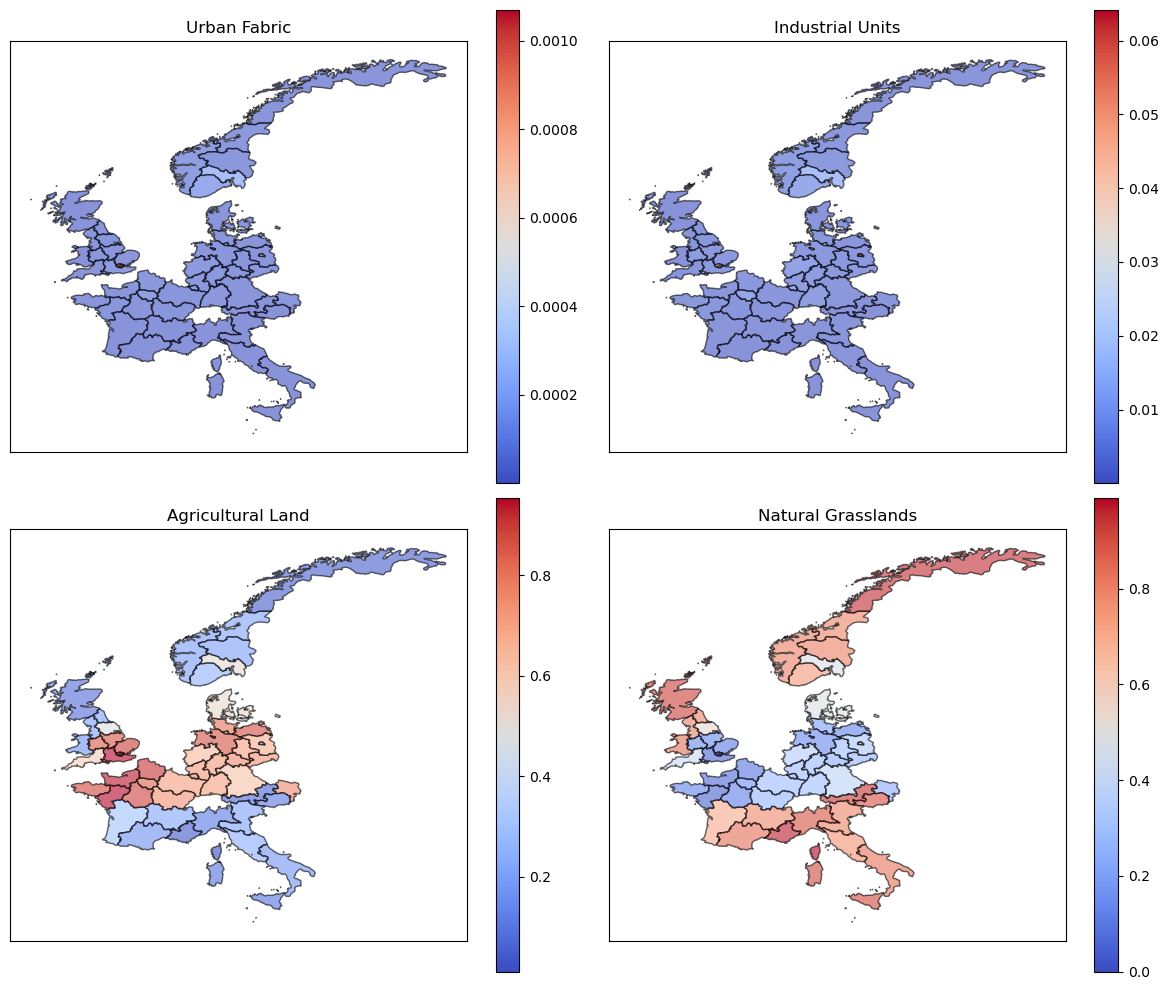

In [108]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Ensure gdf is set with the correct geometry
gdf.set_geometry('geometry', inplace=True)

# Calculate proportions for land types
def calculate_proportions(row):
    total = (row['[111,112] - Urban fabric'] + 
             row['121 - Industrial or commercial units'] + 
             row['[211,231,241] - Agricultural land'] + 
             row['321 - Natural grasslands'])
    
    # Avoid division by zero
    if total == 0:
        return [0, 0, 0, 0]
    
    return [
        row['[111,112] - Urban fabric'] / total,
        row['121 - Industrial or commercial units'] / total,
        row['[211,231,241] - Agricultural land'] / total,
        row['321 - Natural grasslands'] / total
    ]

# Add proportions to DataFrame
gdf[['Residential', 'Industrial', 'Agricultural_land', 'Natural_grasslands']] = gdf.apply(calculate_proportions, axis=1, result_type='expand')

# Set up the subplots
land_types = ['Urban_fabric', 'Industrial_units', 'Agricultural_land', 'Natural_grasslands']
titles = ['Urban Fabric', 'Industrial Units', 'Agricultural Land', 'Natural Grasslands']

fig, axs = plt.subplots(2, 2, figsize=(12, 10))  # 2 rows, 2 columns

# Define color maps
urban_fabric_cmap = plt.cm.viridis  # Intense color map for Urban Fabric
industrial_units_cmap = plt.cm.plasma  # Intense color map for Industrial Units
land_cmap = plt.cm.Blues  # Default color map for other land types

# Normalize the data for Urban Fabric and Industrial Units
urban_fabric_norm = mcolors.Normalize(vmin=gdf['Urban_fabric'].min(), vmax=gdf['Urban_fabric'].max())
industrial_units_norm = mcolors.Normalize(vmin=gdf['Industrial_units'].min(), vmax=gdf['Industrial_units'].max())

# Flatten the axs array for easier iteration
axs = axs.flatten()

# Plot each land type in a separate subplot
for ax, land_type, title in zip(axs, land_types, titles):
    if land_type == 'Urban_fabric':
        gdf.plot(ax=ax, column=land_type, cmap="coolwarm", norm=urban_fabric_norm, legend=True, edgecolor='black', alpha=0.6)
    elif land_type == 'Industrial_units':
        gdf.plot(ax=ax, column=land_type, cmap="coolwarm", norm=industrial_units_norm, legend=True, edgecolor='black', alpha=0.6)
    else:
        gdf.plot(ax=ax, column=land_type, cmap="coolwarm", legend=True, edgecolor='black', alpha=0.6)

    ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylabel('')
   
   # Remove x and y ticks
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])


# Adjust layout
plt.tight_layout()
fig.savefig('Available_Land.png', dpi=900, bbox_inches='tight')  # E
plt.show()


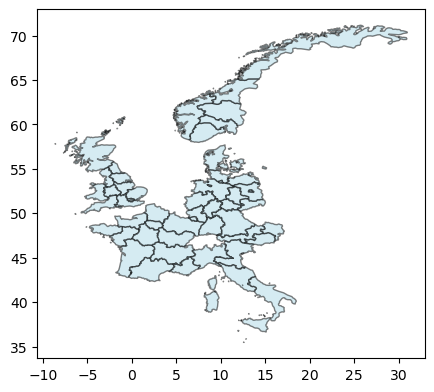

In [84]:
# Plotting the map
fig, ax = plt.subplots(figsize=(5, 6))  # Make the figure smaller

# Plot the underlying geometry of gdf
gdf.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.5)
plt.show()

### Compute Capacity factors

In [67]:
# Define the CORINE codes to check
corine_codes = {
    '[111,112] - Urban fabric': [1, 2],
    '121 - Industrial or commercial units': 3,
    '[211,231,241] - Agricultural land': [12, 13, 18, 19, 20, 21],
    '321 - Natural grasslands': [26, 28, 29, 32]
}

# Define slopes to check
slopes = [40,50,60]
# Define capacity per square kilometer (MW/km^2)
cap_per_sqkm = 2 / 1000

# Initialize a list to store DataFrames for each slope and land type
df_list = []

# Reproject shapes to the correct CRS (EPSG:3035)
shapes = shapes.to_crs("EPSG:3035")

# Loop through each slope value
for s in slopes:
     
    # Loop through each CORINE code (land type)
    for label, code in corine_codes.items():
        
        # Initialize the ExclusionContainer for land type
        excluder_suitable = ExclusionContainer(crs=3035)
        excluder_suitable.add_raster(CORINE, codes=[code], invert=True, crs=3035)
        
        # Calculate land availability matrix for the entire shapes GeoDataFrame
        A = cutout.availabilitymatrix(shapes, excluder_suitable)
        
        # Get the area in square kilometers for all regions at once
        area = cutout.grid.set_index(["y", "x"]).to_crs(3035).area / 1e6  # Convert m^2 to km^2
        area = xr.DataArray(area, dims=("spatial"))

        # Calculate capacity matrix (eligible area * area * capacity per sq. km)
        oka = A.stack(spatial=["y", "x"]) * area * cap_per_sqkm
        
            # Calculate PV potential for this slope and land type for all regions
        pv= cutout.pv(
        panel="CSi",
                        orientation={"slope": float(s), "azimuth": 180.0},
                        matrix = capacity_matrix,
                        index = shapes.index,
                        tracking=None,
                        per_unit=True
                    )
            
            # Flatten the pv DataArray into a DataFrame
        pv_flat = pv.stack(spatial=["dim_0", "time"])
        pv_flat = pv_flat.to_dataframe(name="PV_capacity")

                
                    # Create a DataFrame for the results of this slope and land type, with each value per hour and region
        availability_df = pd.DataFrame({
                        'region': np.repeat(shapes['region'].values, len(pv["time"])),  # Repeat each region across all time steps
                        'slope': s,
                        'land_type': label,
                        'hour': pv_flat["time"].values,  # Hours from the flattened DataArray
                        'PV_capacity': pv_flat["PV_capacity"].values  # Use the flattened PV values
                    })
        
        # Append the DataFrame to the df_list
        df_list.append(availability_df)

# Concatenate all the DataFrames for different slopes and land types
combined_df = pd.concat(df_list)

# Set 'region', 'land_type', and 'slope' as the multi-level index
combined_df.set_index(['region', 'land_type', 'slope'], inplace=True)

# Now, combined_df is a DataFrame with a MultiIndex, where:
# - The first index level represents the region
# - The second index level represents the CORINE land type
# - The third index level represents the slope (tilt)
# - 'PV_capacity' represents the PV capacity for that region, slope, and land type

# You can inspect or analyze the DataFrame as needed
print(combined_df.head())

INFO:atlite.convert:Convert and aggregate 'pv'.
INFO:atlite.convert:Convert and aggregate 'pv'.
INFO:atlite.convert:Convert and aggregate 'pv'.
INFO:atlite.convert:Convert and aggregate 'pv'.
INFO:atlite.convert:Convert and aggregate 'pv'.
INFO:atlite.convert:Convert and aggregate 'pv'.
INFO:atlite.convert:Convert and aggregate 'pv'.
INFO:atlite.convert:Convert and aggregate 'pv'.
INFO:atlite.convert:Convert and aggregate 'pv'.
INFO:atlite.convert:Convert and aggregate 'pv'.
INFO:atlite.convert:Convert and aggregate 'pv'.
INFO:atlite.convert:Convert and aggregate 'pv'.


                                                     hour  PV_capacity
region land_type                slope                                 
AT1    [111,112] - Urban fabric 40    2011-01-01 00:00:00          0.0
                                40    2011-01-01 01:00:00          0.0
                                40    2011-01-01 02:00:00          0.0
                                40    2011-01-01 03:00:00          0.0
                                40    2011-01-01 04:00:00          0.0


In [14]:
combined_df.reset_index(inplace=True)

In [15]:
combined_df

,region,land_type,slope,hour,PV_capacity
0,AT1,"[111,112] - Urban fabric",35,2011-01-01 00:00:00,0.0
1,AT1,"[111,112] - Urban fabric",35,2011-01-01 01:00:00,0.0
2,AT1,"[111,112] - Urban fabric",35,2011-01-01 02:00:00,0.0
3,AT1,"[111,112] - Urban fabric",35,2011-01-01 03:00:00,0.0
4,AT1,"[111,112] - Urban fabric",35,2011-01-01 04:00:00,0.0
...,...,...,...,...,...
3854395,NO08,321 - Natural grasslands,45,2011-12-31 19:00:00,0.0
3854396,NO08,321 - Natural grasslands,45,2011-12-31 20:00:00,0.0
3854397,NO08,321 - Natural grasslands,45,2011-12-31 21:00:00,0.0
3854398,NO08,321 - Natural grasslands,45,2011-12-31 22:00:00,0.0


In [26]:
    # Group by region, hour, and slope and compute the weighted average
    weighted_avg_df2 = combined_df.groupby(['region', 'hour', 'slope'])["PV_capacity"].mean().reset_index(name='weighted_avg_PV_capacity')

weighted_avg_df2.head()

,region,hour,slope,weighted_avg_PV_capacity
0,AT1,2011-01-01 00:00:00,35,0.0
1,AT1,2011-01-01 00:00:00,45,0.0
2,AT1,2011-01-01 01:00:00,35,0.0
3,AT1,2011-01-01 01:00:00,45,0.0
4,AT1,2011-01-01 02:00:00,35,0.0


In [27]:
print(weighted_avg_df2.tail())

       region                hour  slope  weighted_avg_PV_capacity
963595    UKM 2011-12-31 21:00:00     45                       0.0
963596    UKM 2011-12-31 22:00:00     35                       0.0
963597    UKM 2011-12-31 22:00:00     45                       0.0
963598    UKM 2011-12-31 23:00:00     35                       0.0
963599    UKM 2011-12-31 23:00:00     45                       0.0


In [28]:
weighted_avg_df2.to_csv("cf_35_45.csv")

### Visualizations

In [4]:
cf_df = pd.read_csv("cf_all_regions.csv")
cf_df_35_45 = pd.read_csv("cf_35_45.csv")
cf_df_35_45 = cf_df_35_45.rename(columns={"weighted_avg_PV_capacity":"PV_capacity"})
cf_df = pd.concat([cf_df, cf_df_35_45])
cf_df.head()

,Unnamed: 0,region,hour,slope,PV_capacity
0,0,AT1,2011-01-01 00:00:00,10,0.0
1,1,AT1,2011-01-01 00:00:00,20,0.0
2,2,AT1,2011-01-01 00:00:00,30,0.0
3,3,AT1,2011-01-01 00:00:00,40,0.0
4,4,AT1,2011-01-01 01:00:00,10,0.0


### Calulcate Solar PV Factors for each region, technology and slope

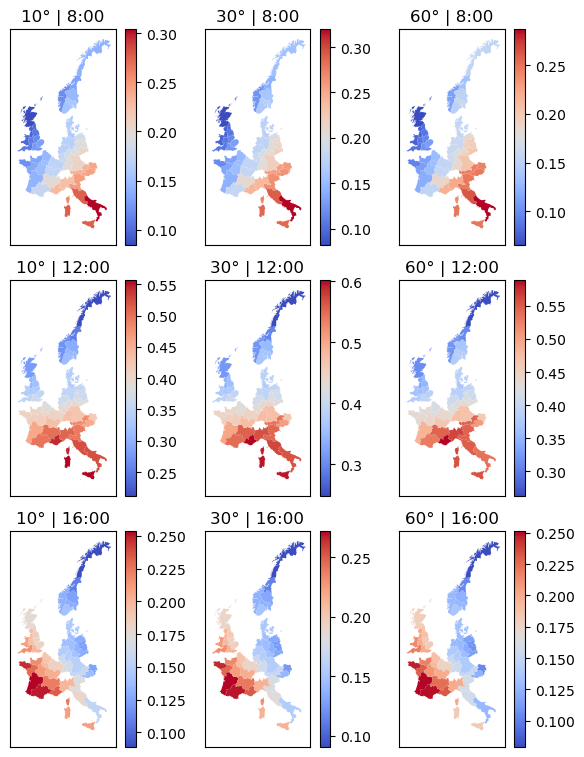

In [56]:
# Define the slopes and hours
slopes = [10, 30, 60]
hours = [8, 12, 16]

# Ensure the 'hour' column is in datetime format
cf_df['hour'] = pd.to_datetime(cf_df['hour'])

# Set up the 3x3 subplot (3 rows and 3 columns)
fig, axes = plt.subplots(3, 3, figsize=(6.4, 8))  #

# Iterate through each hour and slope combination
for row, h in enumerate(hours):
    for col, s in enumerate(slopes):
        # Filter combined_df for the given slope and specific hour
        slope_hour_df = cf_df[
            (cf_df["slope"] == s) & (cf_df["hour"].dt.hour == h)
        ]
        
        # Calculate the average capacity factor per region for this hour and slope
        avg_capacity_df = slope_hour_df.groupby('region')['PV_capacity'].mean().reset_index()

        # Merge the average capacity factor with the shapes GeoDataFrame
        shapes_avg = shapes.merge(avg_capacity_df, on='region')

        # Plot the map for the current hour and slope using a heatmap
        shapes_avg.plot(column='PV_capacity', cmap='coolwarm', legend=True, ax=axes[row, col])
        
    
        
        axes[row, col].set_xticks([])  # Remove x-axis ticks
        axes[row, col].set_yticks([])  # Remove y-axis ticks

        # Set title for the current subplot
        axes[row, col].set_title(f'{s}° | {h}:00')
plt.subplots_adjust(wspace=0.2, hspace=0.2)  # Adjust the spacing between subplots
plt.tight_layout(rect=[0, 0, 1, 0.96])
# Set the general title for the subplot
fig.savefig('CF_Factors.png', dpi=900, bbox_inches='tight')  # Ensure tight bounding box to remove excess whitespace

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title
plt.show()

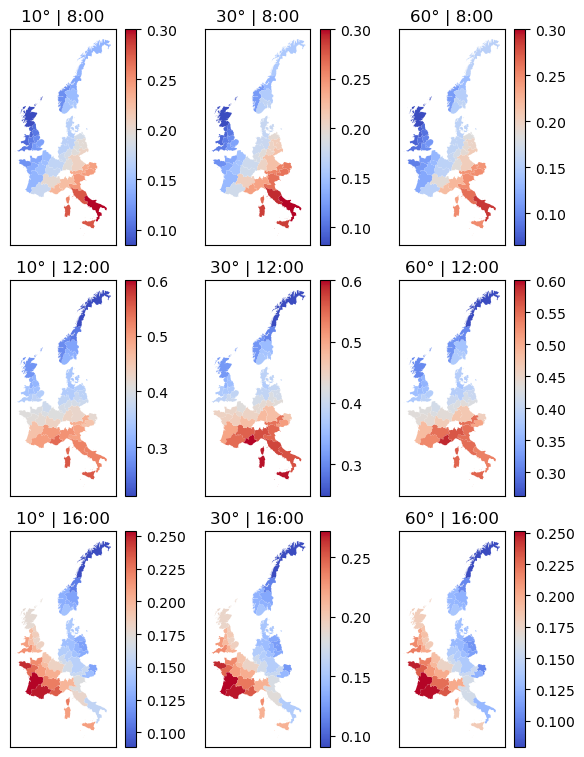

In [57]:
# Define the slopes and hours
slopes = [10, 30, 60]
hours = [8, 12, 16]

# Ensure the 'hour' column is in datetime format
cf_df['hour'] = pd.to_datetime(cf_df['hour'])

# Set up the 3x3 subplot (3 rows and 3 columns)
fig, axes = plt.subplots(3, 3, figsize=(6.4, 8))

# Iterate through each hour and slope combination
for row, h in enumerate(hours):
    for col, s in enumerate(slopes):
        # Filter combined_df for the given slope and specific hour
        slope_hour_df = cf_df[
            (cf_df["slope"] == s) & (cf_df["hour"].dt.hour == h)
        ]
        
        # Calculate the average capacity factor per region for this hour and slope
        avg_capacity_df = slope_hour_df.groupby('region')['PV_capacity'].mean().reset_index()

        # Merge the average capacity factor with the shapes GeoDataFrame
        shapes_avg = shapes.merge(avg_capacity_df, on='region')

        # Set the upper limit for the color scale based on the hour
        if h == 8:
            vmax = 0.3
            vmin = 0.1
        elif h == 12:
            vmax = 0.6
            vmin = 0.3
        elif h == 18:
            vmax = 0.25
            vmin = 0.1
        else:
            vmax = None  # Default value if needed



        # Plot the map for the current hour and slope using a heatmap
        shapes_avg.plot(column='PV_capacity', cmap='coolwarm', legend=True, ax=axes[row, col], vmax=vmax)
        
        axes[row, col].set_xticks([])  # Remove x-axis ticks
        axes[row, col].set_yticks([])  # Remove y-axis ticks

        # Set title for the current subplot
        axes[row, col].set_title(f'{s}° | {h}:00')
        

plt.subplots_adjust(wspace=0.2, hspace=0.2)  # Adjust the spacing between subplots
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Set the general title for the subplot
fig.savefig('CF_Factors.png', dpi=900, bbox_inches='tight')  # Ensure tight bounding box to remove excess whitespace

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title
plt.show()
